In [593]:
import torch
import torchaudio
import torchvision
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch import nn
from torch import cuda
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
from torchvision.utils import save_image

from PIL import Image
from pathlib import Path

import sklearn
from sklearn.utils import compute_class_weight

Use pd.DataFrame to understand data better.

In [594]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join("C:/Users/fatih/OneDrive/Masaüstü/UrbanSound8K/UrbanSound8K/audio", 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [595]:
dataset_df = create_dataset_df("C:/Users/fatih/OneDrive/Masaüstü/UrbanSound8K/metadata/UrbanSound8K.csv")
dataset_df

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,C:/Users/fatih/OneDrive/Masaüstü/UrbanSound8K/...
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,C:/Users/fatih/OneDrive/Masaüstü/UrbanSound8K/...
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,C:/Users/fatih/OneDrive/Masaüstü/UrbanSound8K/...
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,C:/Users/fatih/OneDrive/Masaüstü/UrbanSound8K/...
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,C:/Users/fatih/OneDrive/Masaüstü/UrbanSound8K/...
...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,C:/Users/fatih/OneDrive/Masaüstü/UrbanSound8K/...
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,C:/Users/fatih/OneDrive/Masaüstü/UrbanSound8K/...
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,C:/Users/fatih/OneDrive/Masaüstü/UrbanSound8K/...
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,C:/Users/fatih/OneDrive/Masaüstü/UrbanSound8K/...


In [596]:
class_num = len(dataset_df["class"].unique())

In [597]:
class_tot_num = dataset_df.groupby("classID").slice_file_name.count()
class_tot_num = class_tot_num.to_list()
class_tot_num = [float(i) for i in class_tot_num]
class_tot_num = np.reciprocal(class_tot_num)
%store class_tot_num

Stored 'class_tot_num' (ndarray)


In [598]:
classID_to_name = dataset_df[["classID", "class"]]
classID_to_name

,classID,class
0,3,dog_bark
1,2,children_playing
2,2,children_playing
3,2,children_playing
4,2,children_playing
...,...,...
8727,1,car_horn
8728,1,car_horn
8729,1,car_horn
8730,1,car_horn


In [599]:
spectogram_paths = Path("C:/Users/fatih/OneDrive/Masaüstü/UrbanSound8K/spectrograms")

In [600]:
def dir_summary(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [601]:
dir_summary(spectogram_paths)

There are 10 directories and 0 images in 'C:\Users\fatih\OneDrive\Masaüstü\UrbanSound8K\spectrograms'.
There are 0 directories and 1000 images in 'C:\Users\fatih\OneDrive\Masaüstü\UrbanSound8K\spectrograms\0'.
There are 0 directories and 429 images in 'C:\Users\fatih\OneDrive\Masaüstü\UrbanSound8K\spectrograms\1'.
There are 0 directories and 1000 images in 'C:\Users\fatih\OneDrive\Masaüstü\UrbanSound8K\spectrograms\2'.
There are 0 directories and 1000 images in 'C:\Users\fatih\OneDrive\Masaüstü\UrbanSound8K\spectrograms\3'.
There are 0 directories and 1000 images in 'C:\Users\fatih\OneDrive\Masaüstü\UrbanSound8K\spectrograms\4'.
There are 0 directories and 1000 images in 'C:\Users\fatih\OneDrive\Masaüstü\UrbanSound8K\spectrograms\5'.
There are 0 directories and 374 images in 'C:\Users\fatih\OneDrive\Masaüstü\UrbanSound8K\spectrograms\6'.
There are 0 directories and 1000 images in 'C:\Users\fatih\OneDrive\Masaüstü\UrbanSound8K\spectrograms\7'.
There are 0 directories and 929 images in '

In [602]:
spectogram_paths_list = list(spectogram_paths.glob("*/*.PNG"))

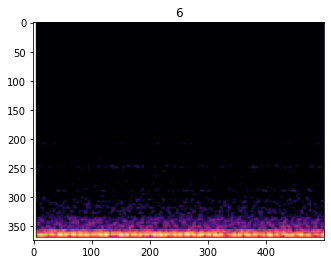

In [603]:
rand_path = random.choice(spectogram_paths_list)
img_classID = rand_path.parent.stem

img = Image.open(random.choice(spectogram_paths_list))
plt.title(img_classID)
plt.imshow(img)

2) Transform DATA
    
    Calculate mean, std. deviation of the dataset in order to Normalize it.

In [605]:
data = datasets.ImageFolder(root=spectogram_paths, transform=transforms.ToTensor())
dataloader = DataLoader(dataset=data, batch_size=32, shuffle=False)

In [606]:
all_labels = [label for _, label  in data]
len(all_labels), data.classes, np.unique(all_labels)

In [607]:
# The imbalance between classes in dataset is calculated and will be used in Loss Function.
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes= np.unique(all_labels),
    y= all_labels)

%store class_weights
class_weights

Stored 'class_weights' (ndarray)


array([0.8732    , 2.03543124, 0.8732    , 0.8732    , 0.8732    ,
       0.8732    , 2.33475936, 0.8732    , 0.93993541, 0.8732    ])

In [608]:
def mean_std(data_loader):
    """
    Returns mean and standard deviation of the given datalaoder.

        Args: dataloader: torch.utils.data.DataLoader object.

        Returns mean: float, std: float
    """
    ch_sum, ch_sqr_sum, num_batches = 0, 0, 0

    for data, _ in data_loader:
        ch_sum = torch.mean(data, dim=[0, 2, 3]) #Dimension: 0 -> batches, 2, 3 -> (H, W)
        ch_sqr_sum = torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    
    mean = ch_sum / num_batches

    #std = sqrt(E[X^2] - (E[X])^2)
    std = (ch_sqr_sum - ch_sum**2)**0.5
    
    return mean, std

In [631]:
mean, std = mean_std(data_loader=dataloader)

In [632]:
print(f"Mean: {mean}\nStandard Deviation: {std}")

Mean: tensor([0.0008, 0.0003, 0.0008])
Standard Deviation: tensor([0.3059, 0.1739, 0.2360])


    2.A) Grayscale, Resize and Normalize

In [611]:
data_transform = transforms.Compose([
    #Resizing to 64x64
    transforms.Resize((128, 128)),
    #Gray-Scale Transformation    
    transforms.ToTensor(),
    transforms.Grayscale(),
    #Normalization
    transforms.Normalize((0.5, ), (0.5, ))
    ])

2.b) data_trans consists of lists [Image, label]

    It allows us to fetch the labeled data directly.

In [612]:
data_trans = datasets.ImageFolder(root=spectogram_paths,
                            transform=data_transform)

class_idxs = data_trans.classes
img, label = data_trans[0]

print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[ 0.9292, -0.4179, -0.9973,  ..., -0.9973, -0.9973, -0.9973],
         [ 0.9371, -0.4100, -0.9964,  ..., -0.9964, -0.9964, -0.9964],
         [ 0.9371, -0.4100, -0.9964,  ..., -0.9964, -0.9955, -0.9877],
         ...,
         [ 0.9371, -0.3737, -0.5938,  ...,  0.3650,  0.3061,  0.1043],
         [ 0.9527,  0.0827, -0.1742,  ...,  0.1041,  0.0824,  0.0085],
         [ 0.9998,  0.9841,  0.9841,  ...,  0.9841,  0.9841,  0.9841]]])
Image shape: torch.Size([1, 128, 128])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


torch.Size([3, 374, 500])


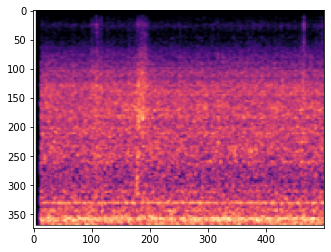

In [613]:
img_orig, _ = data[0]
print(img_orig.shape)
img_orig = img_orig.permute(1,2,0)
plt.imshow(img_orig)

Original shape: torch.Size([1, 128, 128]) -> [color_channels, height, width]
Image permute: torch.Size([128, 128, 1]) -> [height, width, color_channels]


(-0.5, 127.5, 127.5, -0.5)

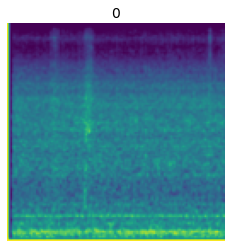

In [614]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.title(class_idxs[label], fontsize=14)
plt.imshow(img_permute)
plt.axis("off")


2.C) Create X_train, y_train, X_val, y_val, X_test ve y_test using data_trans list.

In [615]:
n = len(data_trans)
#Training percentage = %80 - Test %20
n_train = int(0.8 * n)
n_test = n - n_train

data_trans, n_train, n_test, n_test+n_train

(Dataset ImageFolder
     Number of datapoints: 8732
     Root location: C:\Users\fatih\OneDrive\Masaüstü\UrbanSound8K\spectrograms
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Grayscale(num_output_channels=1)
                Normalize(mean=(0.5,), std=(0.5,))
            ),
 6985,
 1747,
 8732)

In [616]:
train, test_data= torch.utils.data.random_split(data_trans, [n_train, n_test])

In [617]:
n = len(train)
#Validation percentage %10
n_train_data = int(0.9 * n)
n_val = n - n_train_data
train_data, val_data = torch.utils.data.random_split(train, [n_train_data, n_val])

Create Dataloader

In [618]:
all_dataloader = DataLoader(dataset=data_trans, batch_size=1, shuffle=False)

train_dataloader = DataLoader(dataset=train_data, batch_size=1, shuffle=True)
train_dataloader_batched = DataLoader(dataset=train_data, batch_size=8, shuffle=True)

val_dataloader = DataLoader(dataset=val_data, batch_size=1, shuffle=True)
val_dataloader_batched = DataLoader(dataset=val_data, batch_size=8, shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)
test_dataloader_batched = DataLoader(dataset=test_data, batch_size=8, shuffle=False)

In [619]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(6286, 699, 1747)

In [620]:
X_batch, y_batch = next(iter(train_dataloader))

In [621]:
X_batch.shape, y_batch.shape

(torch.Size([1, 1, 128, 128]), torch.Size([1]))

2.D) Save splitted data to directory.

In [622]:
spectogram_T_Tensor_path = Path("C:/Users/fatih/OneDrive/Masaüstü/UrbanSound8K/spec_transformed_tensors")
spectogram_T_Images_path = Path("C:/Users/fatih/OneDrive/Masaüstü/UrbanSound8K/spec_transformed_images")

In [623]:
path_train_dataloader_batched = f"{spectogram_T_Tensor_path}/train_dataloader_batched.pth"
torch.save(train_dataloader_batched, path_train_dataloader_batched)

path_test_dataloader_batched = f"{spectogram_T_Tensor_path}/test_dataloader_batched.pth"
torch.save(test_dataloader_batched, path_test_dataloader_batched)

path_val_dataloader_batched = f"{spectogram_T_Tensor_path}/val_dataloader_batched.pth"
torch.save(val_dataloader_batched, path_val_dataloader_batched)

In [624]:
%store path_train_dataloader_batched
%store path_test_dataloader_batched
%store path_val_dataloader_batched

Stored 'path_train_dataloader_batched' (str)
Stored 'path_test_dataloader_batched' (str)
Stored 'path_val_dataloader_batched' (str)


In [625]:
img, lbl = next(iter(train_dataloader))
img.shape, img.squeeze(dim=0).permute(2,1,0).shape, lbl.shape

(torch.Size([1, 1, 128, 128]), torch.Size([128, 128, 1]), torch.Size([1]))

2.D)

    Save Split Data
    
    Save X_train, y_train, X_val, y_val, X_test ve y_test

In [636]:
def save_split_data(dataloader, split_type, path: Path, type_):
    from torchvision.utils import save_image
    """
    Creates directory for the given dataloader and saves transformed images and labels respectively.
        Args:
            datalaoder: Dataloader object,
            split_type: string 
                example: "train", "validation", "test"
            path: Path object
            type: "png" for images, "pt" for tensor

        Returns:
            Hiç birşey
    """
    path = path / split_type

    path_Img_Tensors = path / "Image Tensors Batched"
    path_label_Tensors = path / "Label Tensors Batched"

    path_Images = path / "Images"
    path_labels = path / "Labels"

    if path.is_dir() and path:
        print(f"{path} directory already exists!!!")
        
        if not os.listdir(path):
            print(f"{path} is empty!!!\nSaving Imgs and Labels to current directory.")

            if type_=="pt":
                for idx, (IMG, TARGET) in enumerate(dataloader):
                    torch.save(IMG, f"{path_Img_Tensors}/X_{split_type}_{idx}.{type_}")
                    torch.save(TARGET, f"{path_label_Tensors}/y_{split_type}_{idx}.{type_}")
                print("Saved Successfully !")

            elif type_=="png":
                for idx, (img, target) in enumerate(dataloader):
                    save_image(img.squeeze(), f"{path_Images}/X_{split_type}_{idx}.{type_}")
                    torch.save(target, f"{path_labels}/y_{split_type}_{idx}.{type_}")
                print("Saved Successfully !")  

            else:
                print("type parameter is incorrect!!!")

        else:
            print(f"{path} exists and is not EMPTY!")

    else:
        print(f"{path} does not exist, creating one...")
        
        if type_=="pt":
            path_Img_Tensors.mkdir(parents=True, exist_ok=True)
            path_label_Tensors.mkdir(parents=True, exist_ok=True)

            for idx, (IMG, TARGET) in enumerate(dataloader):
                torch.save(IMG, f"{path_Img_Tensors}/X_{split_type}_{idx}.pt")
                torch.save(TARGET, f"{path_label_Tensors}/y_{split_type}_{idx}.pt")
            print("Saved Successfully !")

        elif type_=="png":
            path_Images.mkdir(parents=True, exist_ok=True)
            path_labels.mkdir(parents=True, exist_ok=True)

            for idx, (img, target) in enumerate(dataloader):
                save_image(img.squeeze(), f"{path_Images}/X_{split_type}_{idx}.{type_}")
                torch.save(target, f"{path_labels}/y_{split_type}_{idx}.{type_}")
            print("Saved Successfully !")
            
        else:
            print("type parameter is incorrect!!!")

In [637]:
save_split_data(train_dataloader_batched, "Train", spectogram_T_Tensor_path, "pt")
save_split_data(val_dataloader_batched, "Validation", spectogram_T_Tensor_path, "pt")
save_split_data(test_dataloader_batched, "Test", spectogram_T_Tensor_path, "pt")

C:\Users\fatih\OneDrive\Masaüstü\UrbanSound8K\spec_transformed_tensors\Train does not exist, creating one...
Saved Successfully !
C:\Users\fatih\OneDrive\Masaüstü\UrbanSound8K\spec_transformed_tensors\Validation does not exist, creating one...
Saved Successfully !
C:\Users\fatih\OneDrive\Masaüstü\UrbanSound8K\spec_transformed_tensors\Test does not exist, creating one...
Saved Successfully !


In [634]:
save_split_data(train_dataloader, "Train", spectogram_T_Images_path, "png")
save_split_data(val_dataloader, "Validation", spectogram_T_Images_path, "png")
save_split_data(test_dataloader, "Test", spectogram_T_Images_path, "png")

C:\Users\fatih\OneDrive\Masaüstü\UrbanSound8K\spec_transformed_images\Train does not exist, creating one...
Saved Successfully !
C:\Users\fatih\OneDrive\Masaüstü\UrbanSound8K\spec_transformed_images\Validation does not exist, creating one...
Saved Successfully !
C:\Users\fatih\OneDrive\Masaüstü\UrbanSound8K\spec_transformed_images\Test does not exist, creating one...
Saved Successfully !


In [642]:
img_Tensor, label = next(iter(train_dataloader))
img_Tensor.min(), img_Tensor.shape, label 

(tensor(-0.9973), torch.Size([1, 1, 128, 128]), tensor([2]))

(-0.5, 127.5, 127.5, -0.5)

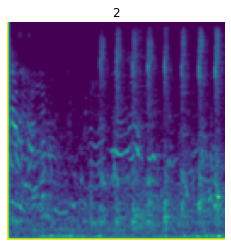

In [643]:
plt.title(label.item())
plt.imshow(img_Tensor.squeeze(dim=0).permute(1,2,0))
plt.axis(False)